<a href="https://colab.research.google.com/github/VictorL85/IA/blob/main/Desafio_final_IA_Victor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size)

print(f"treino: {x_train.shape}")
print(f"teste {x_test.shape}")

treino: (60000, 28, 28, 1)
teste (10000, 28, 28, 1)


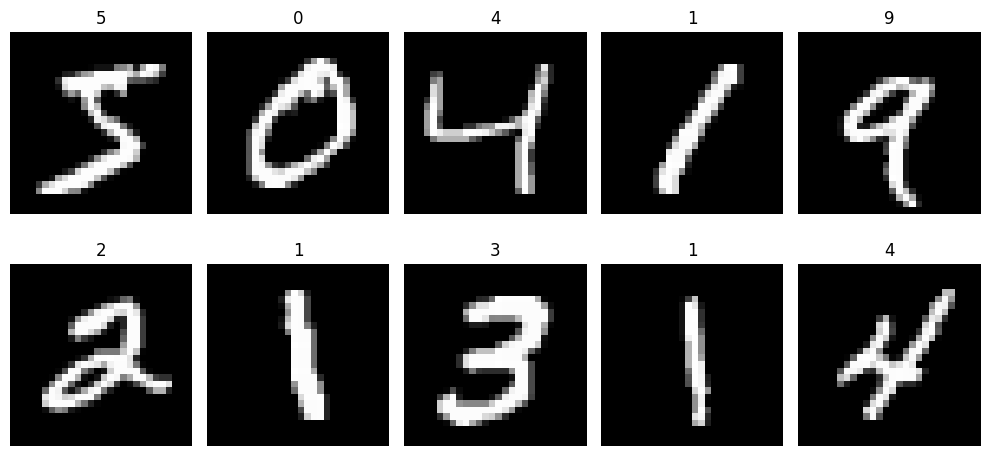

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
latent_dim = 2
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.conv1 = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')
        self.conv2 = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation='relu')
        self.z_mean = layers.Dense(latent_dim, name='z_mean')
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        return z_mean, z_log_var

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Decoder(Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.dense1 = layers.Dense(7 * 7 * 64, activation='relu')
        self.reshape = layers.Reshape((7, 7, 64))
        self.conv_transpose1 = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')
        self.conv_transpose2 = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')
        self.conv_transpose3 = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.reshape(x)
        x = self.conv_transpose1(x)
        x = self.conv_transpose2(x)
        reconstruction = self.conv_transpose3(x)
        return reconstruction

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = Sampling()((z_mean, z_log_var))
        reconstruction = self.decoder(z)
        return reconstruction

encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
vae = VAE(encoder, decoder)

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampling()
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampler((z_mean, z_log_var))
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler((z_mean, z_log_var))
            reconstruction = self.decoder(z)
            flattened_data = tf.reshape(data, shape=[-1, 28 * 28 * 1])
            flattened_reconstruction = tf.reshape(reconstruction, shape=[-1, 28 * 28 * 1])
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(flattened_data, flattened_reconstruction)
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(encoder, decoder)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer=optimizer)
epochs = 10

Resultados da reconstrução ...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


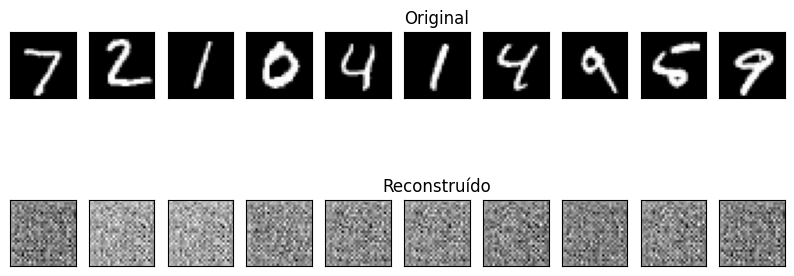


Imagens geradas...


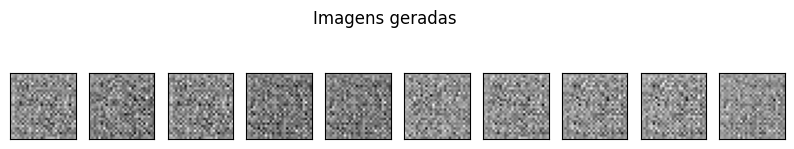

In [ ]:

def plot_reconstruction(vae, dataset, num_images=10):
    for batch in dataset.take(1):
        reconstructed_images = vae.predict(batch)
        plt.figure(figsize=(10, 4))
        for i in range(num_images):
            ax = plt.subplot(2, num_images, i + 1)
            plt.imshow(batch[i].numpy().squeeze(), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == num_images // 2:
                ax.set_title('Original')
            ax = plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == num_images // 2:
                ax.set_title('Reconstruído')
        plt.show()
print("Resultados da reconstrução ...")
plot_reconstruction(vae, test_dataset)

def plot_generated_images(vae, latent_dim, num_images=10):
    random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
    generated_images = vae.decoder(random_latent_vectors)
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i].numpy().squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle('Imagens geradas')
    plt.show()
print("\nImagens geradas...")
plot_generated_images(vae, latent_dim)

In [ ]:
vae.save_weights('Desafio_Final.weights.h5')